# SuperflexPy example 08: Implement GR4J

Author: Marco Dal Molin

Collaborators: Fabrizio Fenicia, Dmitri Kavetski

## What's in this example

This example will cover the following aspects:
- [implement the lumped model GR4J presented in Perrin et al., 2003](https://superflexpy.readthedocs.io/en/latest/popular_models.html#gr4j)

By clicking on the items you will be redirected to the documentation page (when available) that explains the arguments in a more detailed way. 

REFERENCE: Perrin, C., Michel, C., and Andréassian, V.: Improvement of a parsimonious model for streamflow simulation, Journal of Hydrology, 279, 275-289, https://doi.org/10.1016/S0022-1694(03)00225-7, 2003.

## What's not in this example

The following aspects are already covered in other examples:

- [Initialize elements and connect them with a unit](./04_init_single_unit_model.ipynb)
- [Run the model](./01_run_simple_model.ipynb)
- [Change states and parameters](./01_run_simple_model.ipynb)

For this reason we will put only the code need, without further explanations. You can check the other examples by clicking on the items above.

## Do you want to use this example as a script?

Examples of SuperflexPy are created and distributed using Jupyter notebooks because they enable to conjugate runnable code with text explanations. We have decided to not provide the content of the notebooks as script because this would mean duplicating the same content in multiple places, bringing to maintainability problems.

If the user wants to download the content of this notebook as a python script, it is possible following the steps:
1. If not already done, open this notebook using [Binder](https://mybinder.org/v2/gh/dalmo1991/superflexPy/master?filepath=examples%2F08_GR4J.ipynb)
2. Go on File -> Download as -> Python (.py)
3. Select the saving path

The result is a Python script that contains all the markdown text as comment and the code contained inside the cells.

## STEP 1: Initialize the model

GR4J is composed by 4 elements: 2 reservoirs and 2 lag functions. All the elements have already been implemented and can be imported from `superflexpy.implementation.elements.gr4j`.

In [1]:
from superflexpy.implementation.computation.pegasus_root_finding import PegasusPython
from superflexpy.implementation.computation.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.gr4j import InterceptionFilter, ProductionStore, UnitHydrograph1, UnitHydrograph2, RoutingStore, FluxAggregator
from superflexpy.implementation.elements.structure_elements import Transparent, Splitter, Junction
from superflexpy.framework.unit import Unit

x1, x2, x3, x4 = (50.0, 0.1, 20.0, 3.5)

root_finder = PegasusPython()  # Use the default parameters
numerical_approximation = ImplicitEulerPython(root_finder)

interception_filter = InterceptionFilter(id='ir')

production_store = ProductionStore(parameters={'x1': x1, 'alpha': 2.0,
                                               'beta': 5.0, 'ni': 4/9},
                                   states={'S0': 10.0},
                                   approximation=numerical_approximation,
                                   id='ps')

splitter = Splitter(weight=[[0.9], [0.1]],
                    direction=[[0], [0]],
                    id='spl')

unit_hydrograph_1 = UnitHydrograph1(parameters={'lag-time': x4},
                                    states={'lag': None},
                                    id='uh1')

unit_hydrograph_2 = UnitHydrograph2(parameters={'lag-time': 2*x4},
                                    states={'lag': None},
                                    id='uh2')

routing_store = RoutingStore(parameters={'x2': x2, 'x3': x3,
                                         'gamma': 5.0, 'omega': 3.5},
                             states={'S0': 10.0},
                             approximation=numerical_approximation,
                             id='rs')

transparent = Transparent(id='tr')

junction = Junction(direction=[[0, None],  # First output
                               [1, None],  # Second output
                               [None, 0]], # Third output
                    id='jun')

flux_aggregator = FluxAggregator(id='fa')

model = Unit(layers=[[interception_filter],
                     [production_store],
                     [splitter],
                     [unit_hydrograph_1, unit_hydrograph_2],
                     [routing_store, transparent],
                     [junction],
                     [flux_aggregator]],
             id='model')

## STEP 2: Run the model

Now that the mode has been initialized, it can be run. This can be done running the code in the following cell.

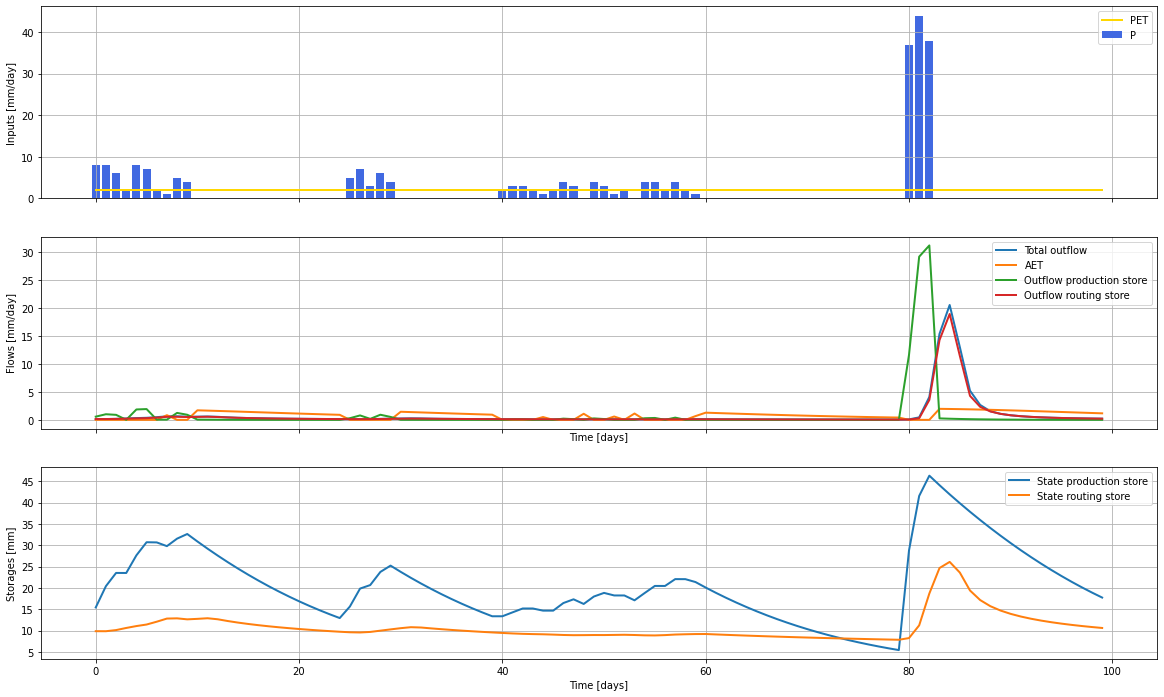

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Fix the seed
SEED = 2
rng = np.random.RandomState(seed=SEED)

# Generate the input
P = np.zeros(100)
P[:10] = rng.randint(10, size=10)
P[25:30] = rng.randint(20, size=5)
P[40:60] = rng.randint(5, size=20)
P[80:83] = rng.randint(30, 50, size=3)
E = np.ones_like(P) * 2.0 # We use a constant PET

# Assign the input
model.set_input([E, P])

# Set the timestep
model.set_timestep(1.0)

# Run the model
model.reset_states()
output = model.get_output()

# Inspect internals
ps_out = model.call_internal(id='ps', method='get_output', solve=False)[0]
ps_e = model.call_internal(id='ps', method='get_aet')[0]
ps_s = model.get_internal(id='ps', attribute='state_array')[:, 0]
rs_out = model.call_internal(id='rs', method='get_output', solve=False)[0]
rs_s = model.get_internal(id='rs', attribute='state_array')[:, 0]

# Plot
fig, ax = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
ax[0].bar(x=np.arange(len(P)), height=P, color='royalblue', label='P')
ax[0].plot(np.arange(len(P)), E, lw=2, color='gold', label='PET')
ax[0].legend()
ax[0].set_ylabel('Inputs [mm/day]')
ax[0].grid(True)
ax[1].plot(np.arange(len(P)), output[0], lw=2, label='Total outflow')
ax[1].plot(np.arange(len(P)), ps_e, lw=2, label='AET')
ax[1].plot(np.arange(len(P)), ps_out, lw=2, label='Outflow production store')
ax[1].plot(np.arange(len(P)), rs_out, lw=2, label='Outflow routing store')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Flows [mm/day]')
ax[1].legend()
ax[1].grid(True)
ax[2].plot(np.arange(len(P)), ps_s, lw=2, label='State production store')
ax[2].plot(np.arange(len(P)), rs_s, lw=2, label='State routing store')
ax[2].set_xlabel('Time [days]')
ax[2].set_ylabel('Storages [mm]')
ax[2].legend()
ax[2].grid(True)
pass